In [ ]:
Summary: We rely on crop mass to describe the general fitness of our crops, which is our key input into Overseed & Cull. 
    
    

## Imports, etc.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/ph/wcdfy27570nc5m2_jjy6g9q00000gn/T/ipykernel_60571/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from plotnine import *
import numpy as np
import datetime
from scipy.stats import norm
from mizani import breaks

In [3]:
import datetime
import os
import pandas as pd
pd.set_option('display.max_rows',500)

import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

## Crop Mass Accuracy

In [ ]:
How often is the harvest mass of a crop actually in the bounds predicted by the crop mass model?

In [18]:
qry = """
  with mass_preds as (
    -- individual crop mass predictions, averaged at the day-crop level
    select p.crop_id,
      component_id,
      hour_starting_at::date as date_starting_at,
      hour_starting_at,
      (case when model_description = 'testing' then '0' else model_description end)::int as model_description,
      avg(q10_predicted_harvest_mass_lbs) as q10_predicted_harvest_mass_lbs,
      avg(q50_predicted_harvest_mass_lbs) as q50_predicted_harvest_mass_lbs,
      avg(q90_predicted_harvest_mass_lbs) as q90_predicted_harvest_mass_lbs,
      avg(failure_probability) as failure_probability,
      datediff('day',c.seeded_on, date_starting_at) as grow_day,
      datediff('day',date_starting_at, completed_on_scheduled) as grow_days_remaining
    from predict.m_crop_mass_preds p
    join warehouse.dm_crops c using (crop_id)
    where c.farm_id = 2
    and grow_days_remaining >= 0
    group by crop_id,
      component_id,
      date_starting_at,
      hour_starting_at,
      model_description,
      grow_day,
      grow_days_remaining
    qualify hour_starting_at = max(hour_starting_at) over (partition by crop_id, date_starting_at)       
  ),
  join_dm_crops as (
  select m.*,
   c.harvest_yield * c.sq_ft_years as harvest_mass_lbs,
   case when harvest_mass_lbs between q10_predicted_harvest_mass_lbs and q90_predicted_harvest_mass_lbs then 1 else 0 end as in_bounds
  from mass_preds m
  join warehouse.dm_crops c using(crop_id)
  where component_id = 12
  )
  select model_description,
    grow_day,
    avg(in_bounds) as in_bounds_rate,
    count(1) as n
  from join_dm_crops
  group by model_description, 
    grow_day
"""
df = pd.read_sql(qry,conn)
df.query('MODEL_DESCRIPTION == 2').sort_values('GROW_DAY')

,MODEL_DESCRIPTION,GROW_DAY,IN_BOUNDS_RATE,N
55,2,2,0.472634,7217
35,2,3,0.485345,9758
12,2,4,0.471367,9814
56,2,5,0.472757,9819
44,2,6,0.478256,9819
38,2,7,0.485915,9798
58,2,8,0.476151,8386
76,2,9,0.479520,9253
41,2,10,0.474080,9298
93,2,11,0.476594,9314


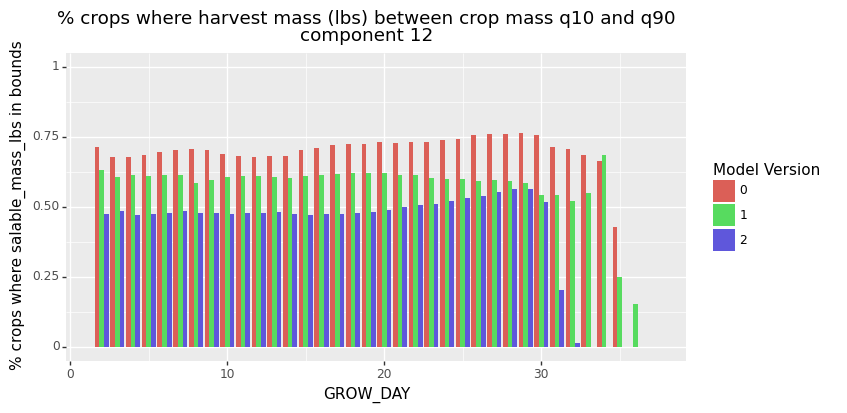

<ggplot: (365900683)>

In [20]:
(
df
    .pipe(lambda d: ggplot(d, aes(x='GROW_DAY',y='IN_BOUNDS_RATE',fill='factor(MODEL_DESCRIPTION)')) + geom_bar(stat='identity',position='dodge') 
          + theme(figure_size=(8,4))
          + ggtitle("% crops where harvest mass (lbs) between crop mass q10 and q90\ncomponent 12")
          + labs(y='% crops where salable_mass_lbs in bounds')
          + ylim(0,1)
          + labs(fill='Model Version'))

)

## When does Crop Mass point us in the right direction?

We would hope that if our ultimate harvest mass is less than the mass we would recoup by replanting, that our crop mass prediction would **also** be less than the mass we recoup by replanting. Unfortunately this doesn't seem to be the case:

In [23]:
qry = """
with masses as (
    select crop_id,
    sq_ft_years * harvest_yield as harvest_mass_lbs, 
    completed_on_planned,
    component_id,
    d.date as window_date
    from warehouse.dm_crops c
    cross join warehouse.dm_dates d 
    where d.date between dateadd('day',-30,completed_on_planned) and completed_on_planned
    and farm_id = 2
    and component_id = 12
    and outcome = 'complete'
),
rolling_mass as (
    select component_id, 
    window_date,
    avg(harvest_mass_lbs) as avg_harvest_mass_lbs,
    stddev(harvest_mass_lbs) as sd_harvest_mass_lbs
    from masses
    group by component_id, 
    window_date
),
mass_preds as (
    -- individual crop mass predictions, averaged at the day-crop level
    select p.crop_id,
    component_id,
    hour_starting_at::date as date_starting_at,
    --hour_starting_at,
    (case when model_description = 'testing' then '0' else model_description end)::int as model_description,
    avg(q10_predicted_harvest_mass_lbs) as q10_predicted_harvest_mass_lbs,
    avg(q50_predicted_harvest_mass_lbs) as q50_predicted_harvest_mass_lbs,
    avg(q90_predicted_harvest_mass_lbs) as q90_predicted_harvest_mass_lbs,
    avg(failure_probability) as failure_probability,
    datediff('day',c.seeded_on, date_starting_at) as grow_day,
    datediff('day',date_starting_at, completed_on_planned) as grow_days_remaining,
    grow_days_remaining / datediff('day',c.seeded_on, completed_on_planned) as fraction_spacetime_remaining      

    from predict.m_crop_mass_preds p
    join warehouse.dm_crops c using (crop_id)
    where c.farm_id = 2
    and grow_days_remaining >= 0
    and outcome <> 'in-flight'
    group by crop_id,
    component_id,
    date_starting_at,
    hour_starting_at,
    model_description,
    grow_day,
    grow_days_remaining,
    seeded_on,
    completed_on_planned
    qualify hour_starting_at = max(hour_starting_at) over (partition by crop_id, date_starting_at)       
),
all_terms as (
    select mp.*, 
      rm.window_date, 
      rm.avg_harvest_mass_lbs,
      rm.sd_harvest_mass_lbs,
      
    
      q10_predicted_harvest_mass_lbs + ((q90_predicted_harvest_mass_lbs - q10_predicted_harvest_mass_lbs)/2) as predicted_harvest_mass_mean,
      (q90_predicted_harvest_mass_lbs - predicted_harvest_mass_mean) / 1.28155                               as predicted_harvest_mass_sd,
      c.sq_ft_years * c.harvest_yield                                                                        as harvest_mass_lbs,
      fraction_spacetime_remaining * avg_harvest_mass_lbs                                                    as recoupable_mass,
      (recoupable_mass - predicted_harvest_mass_mean) / predicted_harvest_mass_sd                            as recoupable_z_score,
      
      case when harvest_mass_lbs < recoupable_mass then 1 else 0 end                                         as recoupable_greater_than_harvest,
      case when recoupable_z_score > 1.0 then 1 else 0 end                                                   as recoupable_greater_than_predicted
    from mass_preds mp
    join rolling_mass rm on (mp.component_id = rm.component_id and mp.date_starting_at = rm.window_date)
    join warehouse.dm_crops c using (crop_id)
    order by grow_day
)
select * from all_terms
where crop_id = 187311
"""
df = pd.read_sql(qry,conn)

How to read the below:
    
* **AVG_HARVEST_MASS_LBS**: rolling average of mass of healthy crops
* **RECOUPABLE_MASS**: AVG_HARVEST_MASS_LBS * (fraction of time left)
* **RECOUPABLE_Z_SCORE**: Z score of RECOUPABLE_MASS relative to the Q10/Q90 predictions
* **RECOUPABLE_GREATER_THAN_HARVEST**: what is says - the mass we get back from planting a new crop with limited time to go is bigger than what the crop actually produced
* **RECOUPABLE_GREATER_THAN_PREDICTED**: RECOUPABLE_Z_SCORE > 1, that is, recoupable mass is 1 standard deviation above the middle of the predicted crop mass distribution



In [24]:
df.sort_values('GROW_DAY')

,CROP_ID,COMPONENT_ID,DATE_STARTING_AT,MODEL_DESCRIPTION,Q10_PREDICTED_HARVEST_MASS_LBS,Q50_PREDICTED_HARVEST_MASS_LBS,Q90_PREDICTED_HARVEST_MASS_LBS,FAILURE_PROBABILITY,GROW_DAY,GROW_DAYS_REMAINING,...,WINDOW_DATE,AVG_HARVEST_MASS_LBS,SD_HARVEST_MASS_LBS,PREDICTED_HARVEST_MASS_MEAN,PREDICTED_HARVEST_MASS_SD,HARVEST_MASS_LBS,RECOUPABLE_MASS,RECOUPABLE_Z_SCORE,RECOUPABLE_GREATER_THAN_HARVEST,RECOUPABLE_GREATER_THAN_PREDICTED
0,187311,12,2022-03-04,1,20.484276,30.414076,40.540520,0.013081,2,28,...,2022-03-04,37.893767,9.026420,30.512398,7.824994,0.0,35.367503,0.620461,1,0
1,187311,12,2022-03-05,1,21.822649,31.622064,40.156605,0.002489,3,27,...,2022-03-05,38.137000,9.266820,30.989627,7.153039,0.0,34.323300,0.466050,1,0
2,187311,12,2022-03-06,1,24.652167,34.709628,44.005193,0.005261,4,26,...,2022-03-06,38.190493,9.319054,34.328680,7.550632,0.0,33.098440,-0.162932,1,0
3,187311,12,2022-03-07,1,25.626962,35.198228,44.321738,0.007350,5,25,...,2022-03-07,38.258849,9.640465,34.974350,7.293814,0.0,31.882362,-0.423919,1,0
4,187311,12,2022-03-08,1,24.189896,33.335958,42.729183,0.053553,6,24,...,2022-03-08,38.382842,9.808413,33.459540,7.233150,0.0,30.706274,-0.380645,1,0
5,187311,12,2022-03-09,1,22.284396,30.407382,39.351901,0.032193,7,23,...,2022-03-09,38.570679,9.703572,30.818149,6.658931,0.0,29.570867,-0.187310,1,0
6,187311,12,2022-03-10,1,33.327982,41.813568,47.921068,0.196067,8,22,...,2022-03-10,38.721991,9.659179,40.624525,5.693530,0.0,28.396114,-2.147773,1,0
7,187311,12,2022-03-11,1,25.032498,33.752054,41.637110,0.014964,9,21,...,2022-03-11,38.940354,9.584333,33.334804,6.478331,0.0,27.258248,-0.937982,1,0
8,187311,12,2022-03-12,1,9.720327,21.100334,29.557227,0.031361,10,20,...,2022-03-12,39.267539,9.565392,19.638777,7.739417,0.0,26.178372,0.844973,1,0
9,187311,12,2022-03-13,1,25.705993,34.904884,42.827811,0.011312,11,19,...,2022-03-13,39.422489,9.641275,34.266902,6.680121,0.0,24.967563,-1.392091,1,0


In [27]:
qry = """
with masses as (
    select crop_id,
    sq_ft_years * harvest_yield as harvest_mass_lbs, 
    completed_on_planned,
    component_id,
    d.date as window_date
    from warehouse.dm_crops c
    cross join warehouse.dm_dates d 
    where d.date between dateadd('day',-30,completed_on_planned) and completed_on_planned
    and farm_id = 2
    and component_id = 12
    and outcome = 'complete'
),
rolling_mass as (
    select component_id, 
    window_date,
    avg(harvest_mass_lbs) as avg_harvest_mass_lbs,
    stddev(harvest_mass_lbs) as sd_harvest_mass_lbs
    from masses
    group by component_id, 
    window_date
),
mass_preds as (
    -- individual crop mass predictions, averaged at the day-crop level
    select p.crop_id,
    component_id,
    hour_starting_at::date as date_starting_at,
    --hour_starting_at,
    (case when model_description = 'testing' then '0' else model_description end)::int as model_description,
    avg(q10_predicted_harvest_mass_lbs) as q10_predicted_harvest_mass_lbs,
    avg(q50_predicted_harvest_mass_lbs) as q50_predicted_harvest_mass_lbs,
    avg(q90_predicted_harvest_mass_lbs) as q90_predicted_harvest_mass_lbs,
    avg(failure_probability) as failure_probability,
    datediff('day',c.seeded_on, date_starting_at) as grow_day,
    datediff('day',date_starting_at, completed_on_planned) as grow_days_remaining,
    grow_days_remaining / datediff('day',c.seeded_on, completed_on_planned) as fraction_spacetime_remaining      

    from predict.m_crop_mass_preds p
    join warehouse.dm_crops c using (crop_id)
    where c.farm_id = 2
    and grow_days_remaining >= 0
    and outcome <> 'in-flight'
    group by crop_id,
    component_id,
    date_starting_at,
    hour_starting_at,
    model_description,
    grow_day,
    grow_days_remaining,
    seeded_on,
    completed_on_planned
    qualify hour_starting_at = max(hour_starting_at) over (partition by crop_id, date_starting_at)       
),
all_terms as (
    select mp.*, 
      rm.window_date, 
      rm.avg_harvest_mass_lbs,
      rm.sd_harvest_mass_lbs,
      
    
      q10_predicted_harvest_mass_lbs + ((q90_predicted_harvest_mass_lbs - q10_predicted_harvest_mass_lbs)/2) as predicted_harvest_mass_mean,
      (q90_predicted_harvest_mass_lbs - predicted_harvest_mass_mean) / 1.28155                               as predicted_harvest_mass_sd,
      c.sq_ft_years * c.harvest_yield                                                                        as harvest_mass_lbs,
      fraction_spacetime_remaining * avg_harvest_mass_lbs                                                    as recoupable_mass,
      (recoupable_mass - predicted_harvest_mass_mean) / predicted_harvest_mass_sd                            as recoupable_z_score,
      
      case when harvest_mass_lbs < recoupable_mass then 1 else 0 end                                         as recoupable_greater_than_harvest,
      case when recoupable_z_score > 1.0 then 1 else 0 end                                                   as recoupable_greater_than_predicted
    from mass_preds mp
    join rolling_mass rm on (mp.component_id = rm.component_id and mp.date_starting_at = rm.window_date)
    join warehouse.dm_crops c using (crop_id)
    order by grow_day
)
select model_description,
  component_id,
  grow_day, 
  recoupable_greater_than_harvest,
  recoupable_greater_than_predicted,
  count(1) as n
from all_terms
group by model_description,
  component_id,
  grow_day,
  recoupable_greater_than_harvest,
  recoupable_greater_than_predicted
"""
df = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [28]:
df.head()

,MODEL_DESCRIPTION,COMPONENT_ID,GROW_DAY,RECOUPABLE_GREATER_THAN_HARVEST,RECOUPABLE_GREATER_THAN_PREDICTED,N
0,0,12,15,1,1,92
1,0,12,14,1,1,78
2,1,12,14,0,1,4
3,1,12,19,1,0,714
4,1,12,5,1,1,28


In [32]:
(
    df
    .assign(total_n = lambda d: d.groupby(['MODEL_DESCRIPTION','COMPONENT_ID','GROW_DAY','RECOUPABLE_GREATER_THAN_HARVEST'])['N'].transform('sum'))
    .query('GROW_DAY==5').query('MODEL_DESCRIPTION==2')
    .assign(pct = lambda d: d['N']/d['total_n'])
)

,MODEL_DESCRIPTION,COMPONENT_ID,GROW_DAY,RECOUPABLE_GREATER_THAN_HARVEST,RECOUPABLE_GREATER_THAN_PREDICTED,N,total_n,pct
17,2,12,5,1,1,30,2621,0.011446
174,2,12,5,1,0,2591,2621,0.988554
200,2,12,5,0,1,61,6461,0.009441
287,2,12,5,0,0,6400,6461,0.990559


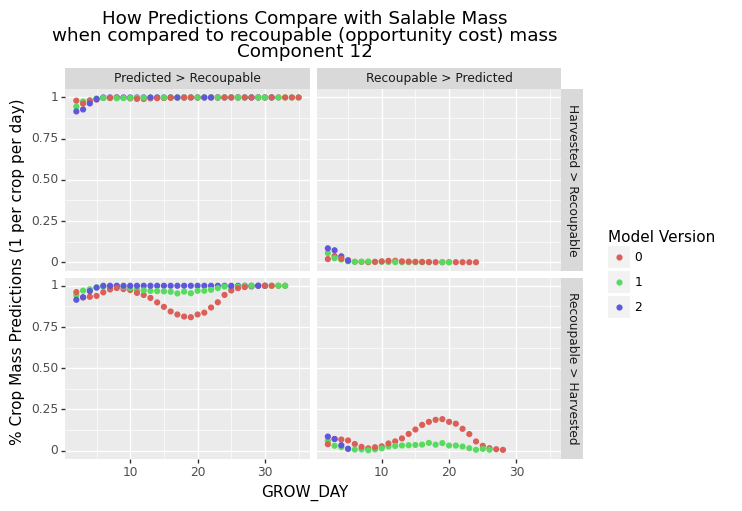

<ggplot: (364660035)>

In [33]:
(
    df
    .assign(total_n = lambda d: d.groupby(['MODEL_DESCRIPTION','COMPONENT_ID','GROW_DAY','RECOUPABLE_GREATER_THAN_HARVEST'])['N'].transform('sum'))

    .assign(pct = lambda d: d['N']/d['total_n'])
    
    .assign(RECOUPABLE_GREATER_THAN_SALABLE = lambda d: d['RECOUPABLE_GREATER_THAN_HARVEST'].map({0:'Harvested > Recoupable',1:'Recoupable > Harvested'}))
    .assign(RECOUPABLE_GREATER_THAN_PREDICTED = lambda d: d['RECOUPABLE_GREATER_THAN_PREDICTED'].map({0:'Predicted > Recoupable',1:'Recoupable > Predicted'}))
    
    .pipe(lambda d: ggplot(d, aes(x='GROW_DAY',y='pct',color='factor(MODEL_DESCRIPTION)')) 
          + geom_point()
          + labs(y="% Crop Mass Predictions (1 per crop per day)",color='Model Version')
         + facet_grid(['RECOUPABLE_GREATER_THAN_SALABLE','RECOUPABLE_GREATER_THAN_PREDICTED'])
         + ggtitle("How Predictions Compare with Salable Mass\nwhen compared to recoupable (opportunity cost) mass\nComponent 12"))
)

Read this plot like a confusion matrix: we want to see that if Harvest mass > recoupable mass, then the prediction should show this as well. This would look like the top left plot and bottom right plot being higher than top right and bottom left. 

Instead, while top left is where it belongs the bottom right is low and flat - **in the cases where our harvest poundage is less than what we would get from replanting, crop mass tells us otherwise**.

Going back to our crop mass accuracy plot:

In [51]:
qry = """
  with mass_preds as (
    -- individual crop mass predictions, averaged at the day-crop level
    select p.crop_id,
      component_id,
      hour_starting_at::date as date_starting_at,
      hour_starting_at,
      (case when model_description = 'testing' then '0' else model_description end)::int as model_description,
      avg(q10_predicted_harvest_mass_lbs) as q10_predicted_harvest_mass_lbs,
      avg(q50_predicted_harvest_mass_lbs) as q50_predicted_harvest_mass_lbs,
      avg(q90_predicted_harvest_mass_lbs) as q90_predicted_harvest_mass_lbs,
      avg(failure_probability) as failure_probability,
      datediff('day',c.seeded_on, date_starting_at) as grow_day,
      datediff('day',date_starting_at, completed_on_scheduled) as grow_days_remaining
    from predict.m_crop_mass_preds p
    join warehouse.dm_crops c using (crop_id)
    where c.farm_id = 2
    and grow_days_remaining >= 0
    group by crop_id,
      component_id,
      date_starting_at,
      hour_starting_at,
      model_description,
      grow_day,
      grow_days_remaining
    qualify hour_starting_at = max(hour_starting_at) over (partition by crop_id, date_starting_at)       
  ),
  join_dm_crops as (
  select m.*,
   c.harvest_yield * c.sq_ft_years as harvest_mass_lbs,
   round(harvest_mass_lbs/10)*10 as harvest_mass_lbs_bins,
   case when harvest_mass_lbs between q10_predicted_harvest_mass_lbs and q90_predicted_harvest_mass_lbs then 1 else 0 end as in_bounds
  from mass_preds m
  join warehouse.dm_crops c using(crop_id)
  where component_id = 12
  )
    select model_description,
    grow_day,
    harvest_mass_lbs_bins,
    avg(in_bounds) as in_bounds_rate,
    count(1) as n
  from join_dm_crops
  group by model_description, 
    grow_day,
    harvest_mass_lbs_bins
"""
df = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 126 rows containing missing values.


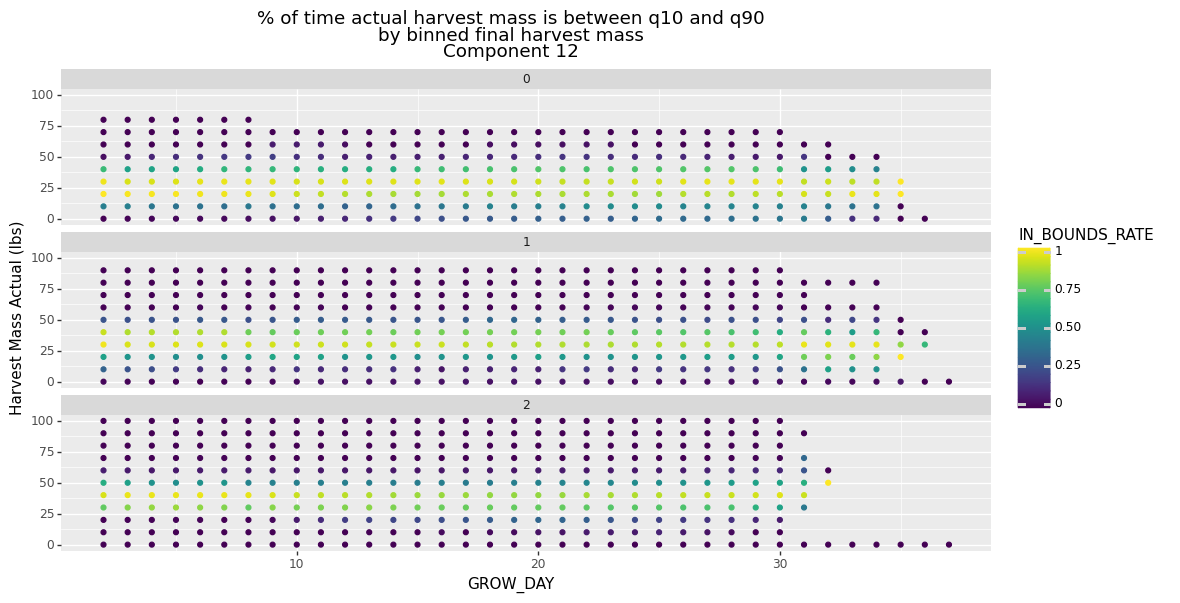

<ggplot: (367954390)>

In [58]:
(
    ggplot(df, aes(x='GROW_DAY',y='HARVEST_MASS_LBS_BINS',color='IN_BOUNDS_RATE')) 
    + geom_point() 
    + facet_wrap('MODEL_DESCRIPTION',ncol=1)
    + theme(figure_size=(12,6))
    + ylim(0,100)
    + labs(y='Harvest Mass Actual (lbs)')
    + ggtitle("% of time actual harvest mass is between q10 and q90\nby binned final harvest mass\nComponent 12")
)

Bottom line: **crop mass isn't useful for predicting crop sizes outside a narrow band**.